# Import depecdencies

In [1]:
import os
import glob
import shutil
import random
import matplotlib
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import os.path as osp
import seaborn as sns
import os.path as osp
from plottable.cmap import normed_cmap
import matplotlib.pyplot as plt
from matplotlib.cm import Greens, Reds

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from plottable import ColumnDefinition
from plottable import Table
from plottable.formatters import decimal_to_percent
from configs.general import EXPERIMENT_INFO_PATH, BASE_DIR,\
      EXPERIMENT_BASE_DIR, EXPERIMENT_COLS, DATA_FILTERING_POLICIES,\
          DATA_RETRIEVAL_POLICIES, PHASES, FILTERING_EXPERIMENT_COLS,\
          FILTERING_EXPERIMENT_BASE_DIR, FILTERING_EXPERIMENT_INFO_PATH, METRICS_BASE_DIR

from metric.level2.correctness import Correctness
from utils.plot import draw_stacked_bars
METRIC_NAME = "correctness"

scaler = MinMaxScaler()

# Calculate correctness for each experiment 

In [10]:
def load_examins_auc(path, index_col):
    experiments_with_corretness_auc = None
    try:
        experiments_with_corretness_auc = pd.read_csv(path, index_col=index_col)
    except Exception as e:
        print(e)
    return experiments_with_corretness_auc

def load_experiments(path, index_col):
    experiments = pd.read_csv(path, index_col=index_col)
    try:
        experiments.drop(columns=['test_acc'], inplace=True)
    except Exception as e:
        print(e)
    return experiments

def filter_out_auc_calculated_examins(experiments, experiments_with_corretness_auc):
    experiments['has_auc'] = False
    for idx in experiments_with_corretness_auc.index:
        if idx in experiments.index:
            experiments.loc[idx, 'has_auc'] = True
    
    return experiments[(experiments['has_auc'] == False)]

In [ ]:
experiments = load_experiments(EXPERIMENT_INFO_PATH, index_col='index')
experiments = experiments[(experiments['done'] == True) & (experiments['np'] != "np=0.0")]
experiments_with_corretness_auc = load_examins_auc(osp.join(METRICS_BASE_DIR, f"{METRIC_NAME}_auc.csv"), index_col='index')

if experiments_with_corretness_auc is not None and not experiments_with_corretness_auc.empty:
    experiments = filter_out_auc_calculated_examins(experiments, experiments_with_corretness_auc)
for phase in PHASES:
    experiments[f"{METRIC_NAME}-{phase}-auc"] = 0.0

for index, row in experiments.iterrows():
    metric = Correctness(
        experiment_dir=osp.join(EXPERIMENT_BASE_DIR, *[str(row[col]) for col in EXPERIMENT_COLS]),
        phases=PHASES,
        folds=row['folds'],
        epochs=row['epochs'],
        epoch_skip=2,
        raw_dataset_path=f"/home/vision/Repo/cleanset/dataset/{row['dataset']}/info.csv")
    correctness = metric.calculate_metric_per_phase(scale=True)
    auc = metric.calculate_auc_per_phase(correctness)
    print(index, 'auc: ', auc)
    for phase in PHASES:
        experiments.at[index, f"{METRIC_NAME}-{phase}-auc"] = auc[phase]
        experiments.at[index, f"has_auc"] = True


In [ ]:
experiments.head()

In [19]:
experiments = experiments[(experiments["has_auc"] == True)]
path = osp.join(METRICS_BASE_DIR, f"{METRIC_NAME}_auc.csv")
if osp.exists(path):
    shutil.copy(path, path+".swp")
else:
    os.makedirs(METRICS_BASE_DIR, exist_ok=True)
if experiments_with_corretness_auc is not None and not experiments_with_corretness_auc.empty:
    experiments_with_corretness_auc = experiments_with_corretness_auc._append(experiments.drop(columns=['has_auc']))
    experiments_with_corretness_auc.sort_index(inplace=True)
    experiments_with_corretness_auc.to_csv(path)
else:
    experiments.drop(columns=['has_auc'], inplace=True)
    experiments.sort_index(inplace=True)
    experiments.to_csv(osp.join(path))

# Best Settings with xception model based on correctness AUC

### Plot Best AUC for train and validation phase

In [3]:
table = pd.read_csv(osp.join(METRICS_BASE_DIR, f"{METRIC_NAME}_auc.csv"), index_col='index')
table = table.dropna()
# table = table[table['model'] == 'xception']

In [4]:
train_max_auc_rows = table.loc[table.groupby(['np', 'ns'])[f'{METRIC_NAME}-train-auc'].idxmax()]
val_max_auc_rows = table.loc[table.groupby(['np', 'ns'])[f'{METRIC_NAME}-validation-auc'].idxmax()]

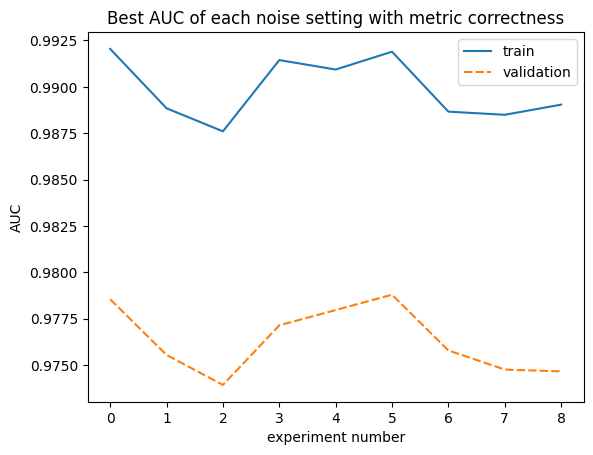

In [5]:
plt.title(f'Best AUC of each noise setting with metric {METRIC_NAME}')
sns.lineplot(data=pd.DataFrame({'train': train_max_auc_rows.reset_index()[f'{METRIC_NAME}-train-auc'], 'validation': val_max_auc_rows.reset_index()[f'{METRIC_NAME}-validation-auc']}))
plt.xlabel('experiment number')
plt.ylabel('AUC')
plt.show()
plt.close()

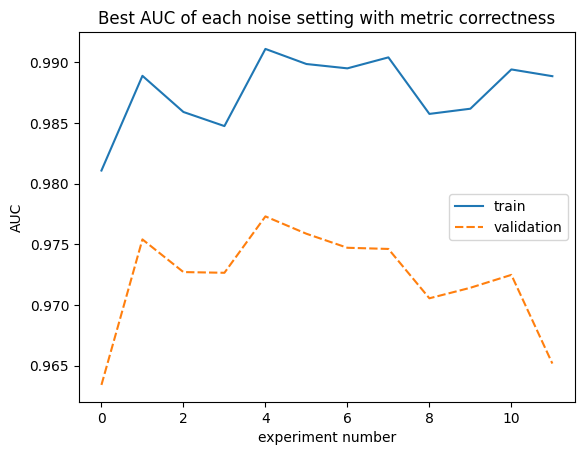

In [6]:
# based on above plot we select 'train' phase
max_auc_rows = train_max_auc_rows.copy()
winner_phase = 'train'

### Plot best settings for each noise setting according to metric

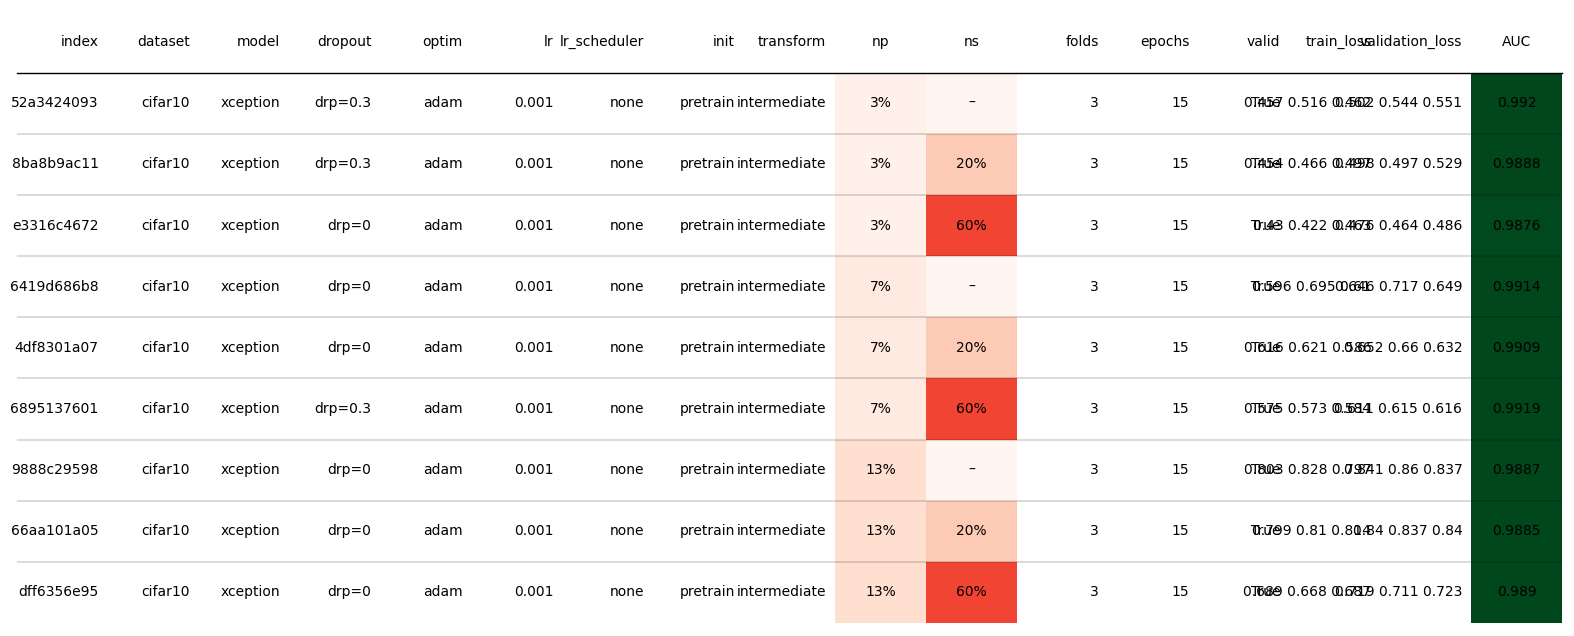

In [7]:
# Init a figure
fig, ax = plt.subplots(figsize=(20, 8))
df = max_auc_rows.copy()
df['np'] = max_auc_rows['np'].str.replace('np=', '').astype(float)
df['ns'] = max_auc_rows['ns'].str.replace('ns=', '').astype(float)
df['lr'] = max_auc_rows['lr'].str.replace('lr=', '').astype(float)
df['AUC'] = max_auc_rows['correctness-train-auc'].round(4)
df = df.drop(columns=[f'{METRIC_NAME}-train-auc', f'{METRIC_NAME}-validation-auc', 'done'])

tab = Table(df, column_definitions=[
    ColumnDefinition(name="AUC", cmap=Greens, textprops= {"ha": "center"}),
    ColumnDefinition(name="np", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent),
    ColumnDefinition(name="ns", cmap=Reds, textprops={"ha": "center"}, formatter=decimal_to_percent)
])

# Display the output
plt.show()

In [8]:
print(f"Top experiments based on metric {METRIC_NAME}: ", df.index.tolist())

Top experiments based on metric correctness:  ['52a3424093', '8ba8b9ac11', 'e3316c4672', '6419d686b8', '4df8301a07', '6895137601', '9888c29598', '66aa101a05', 'dff6356e95']


### Generate database for filtering policies based on this metric

In [12]:
# Generate database for filtering policies based on this metric
new_df = pd.DataFrame()
for experiment_index in max_auc_rows.index.tolist():
    for filtering_policy in DATA_FILTERING_POLICIES:
        for retrieval_policy in DATA_RETRIEVAL_POLICIES:
            new_df = new_df._append({'basic_experiment_index': experiment_index, 'data_filtering_policy': filtering_policy, 'data_retrieval_policy': retrieval_policy}, ignore_index=True)
new_df['based_on'] = METRIC_NAME
new_df['done'] = False
new_df.index.name = 'index'

path = osp.join(BASE_DIR, 'filtering_experiments.csv')
if osp.exists(path):
    shutil.copy(path, path+".swp")
    old_df = pd.read_csv(path, index_col='index')
    new_df = new_df._append(old_df, ignore_index=True)
    new_df = new_df.drop_duplicates(subset=['basic_experiment_index', 'data_filtering_policy', 'data_retrieval_policy', 'based_on'], keep='last').sort_values('basic_experiment_index').reset_index(drop=True)
if not osp.isdir(osp.dirname(path)):
    os.makedirs(osp.dirname(path))
new_df.to_csv(path, index_label='index')

### Write metric per sample for best experiment settings

In [ ]:
for index, row in max_auc_rows.iterrows():
    metric = Correctness(
        experiment_dir=osp.join(EXPERIMENT_BASE_DIR, *[str(row[col]) for col in EXPERIMENT_COLS]),
        phases=PHASES,
        folds=row['folds'],
        epochs=row['epochs'],
        epoch_skip=2,
        raw_dataset_path=f"/home/vision/Repo/cleanset/dataset/{row['dataset']}/info.csv")
    correctness = metric.calculate_correctness_per_phase(scale=True)
    correctness = correctness[correctness['phase']==winner_phase].drop(columns=['phase'])
    correctness.set_index('sample', inplace=True)
    path = osp.join(metric.experiment_dir, f"{METRIC_NAME}_per_sample.csv")
    if osp.exists(path):
        print(f"correctness auc already exist in {path}")
        continue
    correctness.to_csv(path, index='sample')

# Best settings based on correctness AUC

In [15]:
table = pd.read_csv(osp.join(METRICS_BASE_DIR, f"{METRIC_NAME}_auc.csv"), index_col='index')
table = table.dropna()
train_max_auc_rows = table.loc[table.groupby(['np', 'ns'])[f'{METRIC_NAME}-train-auc'].idxmax()]
val_max_auc_rows = table.loc[table.groupby(['np', 'ns'])[f'{METRIC_NAME}-validation-auc'].idxmax()]

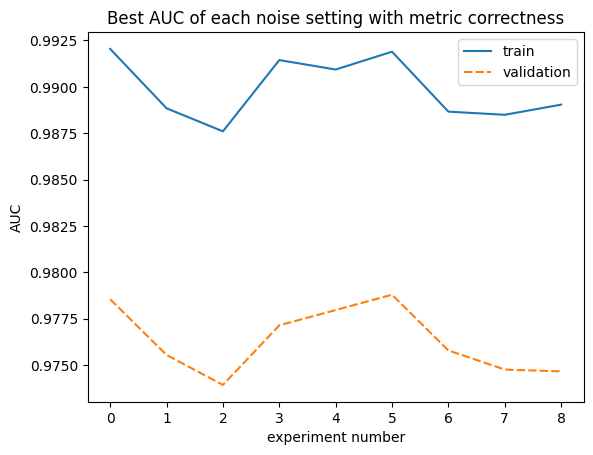

In [16]:
plt.title(f'Best AUC of each noise setting with metric {METRIC_NAME}')
sns.lineplot(data=pd.DataFrame({'train': train_max_auc_rows.reset_index()[f'{METRIC_NAME}-train-auc'], 'validation': val_max_auc_rows.reset_index()[f'{METRIC_NAME}-validation-auc']}))
plt.xlabel('experiment number')
plt.ylabel('AUC')
plt.show()
plt.close()

In [17]:
train_max_auc_rows.head()

,dataset,model,dropout,optim,lr,lr_scheduler,init,transform,np,ns,folds,epochs,done,valid,train_loss,validation_loss,correctness-train-auc,correctness-validation-auc
index,,,,,,,,,,,,,,,,,,
52a3424093,cifar10,xception,drp=0.3,adam,lr=0.001,none,pretrain,intermediate,np=0.03,ns=0.0,3,15,True,True,0.457 0.516 0.462,0.502 0.544 0.551,0.992043,0.978085
8ba8b9ac11,cifar10,xception,drp=0.3,adam,lr=0.001,none,pretrain,intermediate,np=0.03,ns=0.2,3,15,True,True,0.454 0.466 0.497,0.498 0.497 0.529,0.988844,0.975550
e3316c4672,cifar10,xception,drp=0,adam,lr=0.001,none,pretrain,intermediate,np=0.03,ns=0.6,3,15,True,True,0.43 0.422 0.463,0.476 0.464 0.486,0.987601,0.973934
6419d686b8,cifar10,xception,drp=0,adam,lr=0.001,none,pretrain,intermediate,np=0.07,ns=0.0,3,15,True,True,0.596 0.695 0.61,0.646 0.717 0.649,0.991441,0.977144
4df8301a07,cifar10,xception,drp=0,adam,lr=0.001,none,pretrain,intermediate,np=0.07,ns=0.2,3,15,True,True,0.616 0.621 0.586,0.652 0.66 0.632,0.990933,0.977970


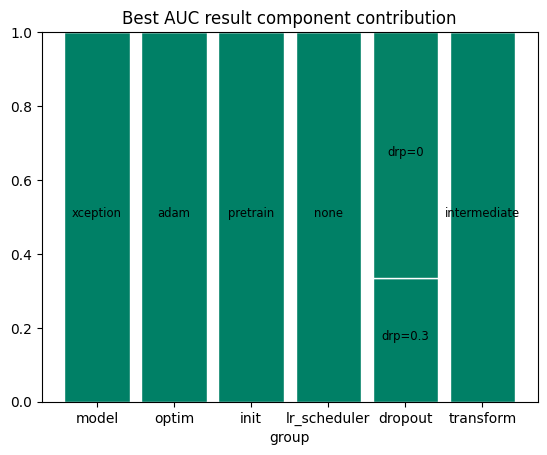

In [18]:
train_max_auc_rows = train_max_auc_rows[['model', 'optim', 'init', 'lr_scheduler', 'dropout', 'transform']]
draw_stacked_bars(train_max_auc_rows)

# Test acc before and after filtering data based on correctness

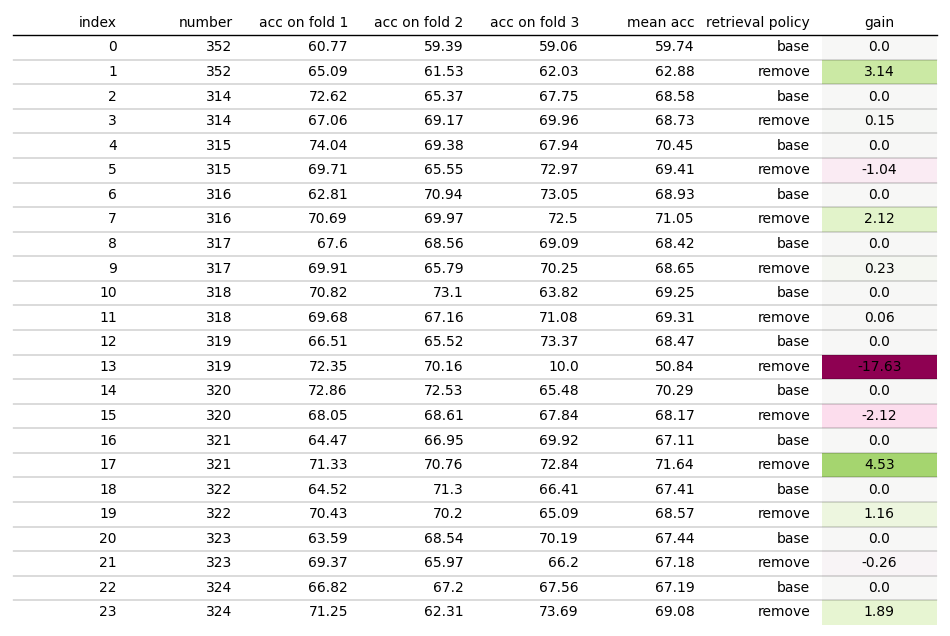

In [10]:
METRIC_NAME = "correctness"
BEST_PHASE = 'train'

result = pd.DataFrame()
try:
    target_experiments_indices = max_auc_rows.index.values()
except:
    target_experiments_indices = [352, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324]

target_experiments = pd.read_csv(EXPERIMENT_INFO_PATH, index_col='index').iloc[target_experiments_indices]
filtering_experience = pd.read_csv(FILTERING_EXPERIMENT_INFO_PATH, index_col='index')
filtering_experience = filtering_experience[filtering_experience['based_on'] == 'correctness']
for index, row in target_experiments.iterrows():
    fex = filtering_experience[filtering_experience['basic_experiment_index'].isin([index]) & \
                                (filtering_experience['done'] == True)]
    test_acc = [float(x) for x in row['test_acc'].split()]

    result = result._append({
        'number': index,
        'acc on fold 1': test_acc[0],
        'acc on fold 2': test_acc[1],
        'acc on fold 3': test_acc[2],
        'mean acc': np.mean(test_acc).round(2),
        'retrieval policy': 'base',
        }, ignore_index = True)

    for findex, frow in fex.iterrows():
        test_acc = [float(x) for x in frow['test_acc'].split()]
        result = result._append({
            'number': index,
            'acc on fold 1': test_acc[0],
            'acc on fold 2': test_acc[1],
            'acc on fold 3': test_acc[2],
            'mean acc': np.mean(test_acc).round(2),
            'retrieval policy': frow['data_retrieval_policy'],
            }, ignore_index = True)

base_result = pd.DataFrame()
base_result['number'] = result['number']
base_result['base acc'] = 0.0
for index, row in base_result.iterrows():
    base_result.at[index, 'base acc'] = result[(result['number'] == row['number']) & (result['retrieval policy'] == 'base')].iloc[0]['mean acc']
gain = ((result['mean acc'] - base_result['base acc'])).round(2)
result['gain'] = gain

# Init a figure
fig, ax = plt.subplots(figsize=(12, 8))
tab = Table(result, column_definitions=[
    ColumnDefinition(
        name="gain",
        cmap=normed_cmap(
            result["gain"],
            cmap=matplotlib.cm.PiYG, num_stds=2.5),
        textprops={"ha": "center"})
])
# Display the output
plt.show()
